**Titanic Survival Prediction Project**

This projects attempts to predict which passengers on the Titanic ship survived, using a number of features such as ticket class, sex, age etc. This is a binary classification problem.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import xgboost as xgb

In [2]:
data = pd.read_csv("titanic/train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**1. Exploratory Data Analysis**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We notice that the classes are slightly imbalanced in the training set.

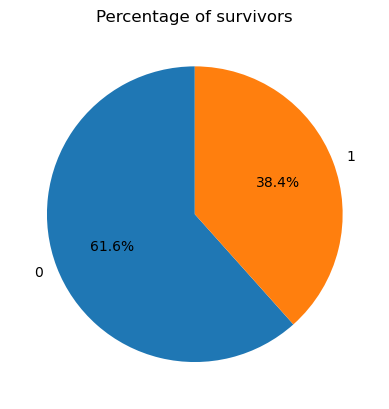

In [5]:
data['Survived'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("Percentage of survivors")
plt.ylabel('')
plt.show()

In [6]:
data_train = data.copy()

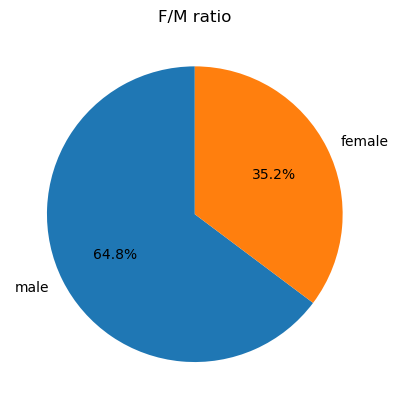

In [7]:
data_train['Sex'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("F/M ratio")
plt.ylabel('')
plt.show()

We notice that women had a much higher survival rate than men.

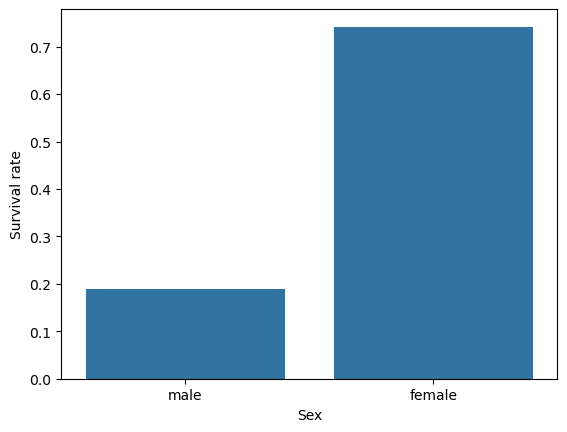

In [8]:
sns.barplot(x='Sex', y='Survived', data=data_train, errorbar=None)
plt.ylabel("Survival rate")
plt.show()

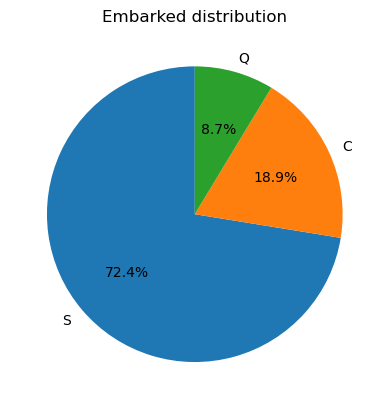

In [9]:
data_train['Embarked'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("Embarked distribution")
plt.ylabel('')
plt.show()

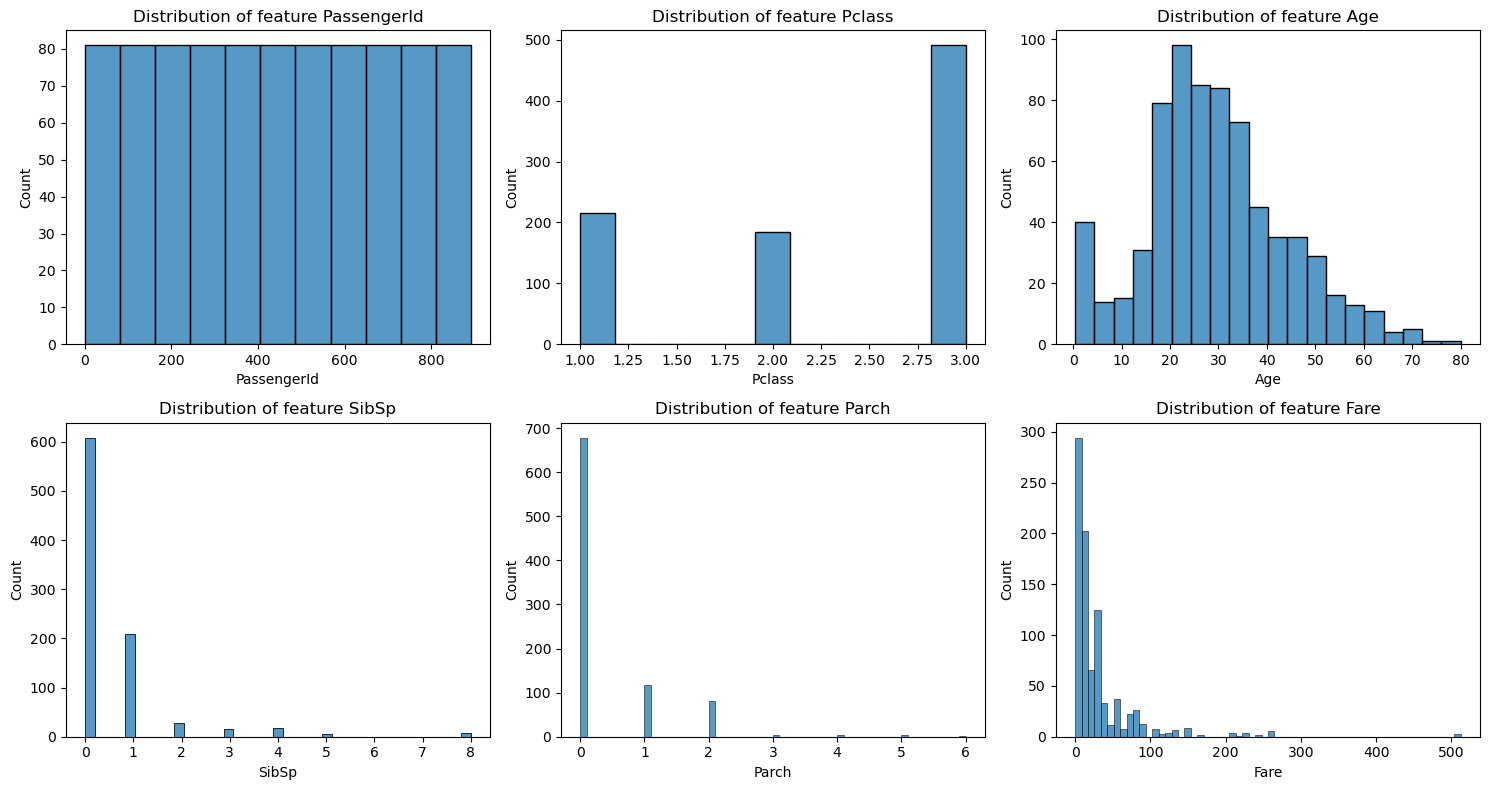

In [10]:
numeric_cols = data_train.select_dtypes(include=['int64', 'float64']).columns.drop('Survived')

n_cols = 3
n_rows = math.ceil(len(numeric_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(data_train[col].dropna(), ax=axes[i])
    axes[i].set_title(f"Distribution of feature {col}")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

From the numerical attributes, ticket class and fare seem to be somewhat correlated with the target feature.

In [11]:
for col in numeric_cols:
    valid_idx = data_train[col].notna()
    corr = np.corrcoef(data_train.loc[valid_idx, col], data_train.loc[valid_idx, 'Survived'])[0, 1]
    print(f"Correlation {col} with Survived: {corr:.2f}")

Correlation PassengerId with Survived: -0.01
Correlation Pclass with Survived: -0.34
Correlation Age with Survived: -0.08
Correlation SibSp with Survived: -0.04
Correlation Parch with Survived: 0.08
Correlation Fare with Survived: 0.26


Obviously, class and fare are quite correlated with each other.

In [12]:
corr_fare_class = np.corrcoef(data_train["Pclass"], data_train["Fare"])[0, 1]
print(f"Corellation class-fare: {corr_fare_class}")

Corellation class-fare: -0.5494996199439075


We notice that the Cabin attribute has a lot of missing values. We try to find out whether it can be used in a useful way by finding the survival rate for each of the cabin groups (given by the first letter).

In [13]:
data_train["CabinLetter"] = data_train["Cabin"].str[0].fillna("Unknown")

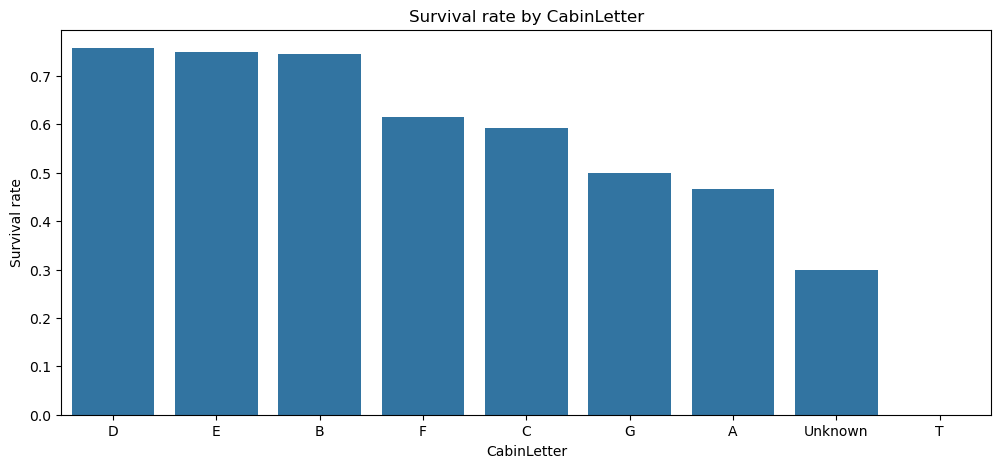

In [14]:
cabin_survival_rate = data_train.groupby('CabinLetter')['Survived'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,5))
sns.barplot(x=cabin_survival_rate.index, y=cabin_survival_rate.values)
plt.ylabel("Survival rate")
plt.xlabel("CabinLetter")
plt.title("Survival rate by CabinLetter")
plt.xticks(rotation=0)
plt.show()

It seems that that passengers whose cabin was unknown had a much lower survival rate, so we add this binary feature to the dataset.

In [15]:
data_train['CabinKnown'] = data_train['Cabin'].notna().astype(int)

Indeed, there is a decent correlation between CabinKnown and the target.

In [16]:
corr = np.corrcoef(data_train['CabinKnown'], data_train['Survived'])[0, 1]
print(f"Correlation CabinKnown with Survived: {corr:.2f}")

Correlation CabinKnown with Survived: 0.32


Cabin and CabinLetter don't seem to give any more useful information, so we drop them.

In [17]:
data_train = data_train.drop(["Cabin", "CabinLetter"], axis=1)

**2. Preprocessing**

From the "Name" feature, the title (Mr., Mrs. etc) could be useful, potentially indicating age or social status.

In [18]:
def extract_title(name):
    match = re.search(r', (\w+)\.', name)
    if match:
        return match.group(1)
    return "Unknown"

In [19]:
data_train['Title'] = data_train['Name'].apply(extract_title)

title_counts = data_train['Title'].value_counts()

rare_titles = title_counts[title_counts < 10].index

data_train['Title'] = data_train['Title'].replace(rare_titles, 'Rare')

We drop the features that are clearly irrelevant.

In [20]:
data_train = data_train.drop(columns=['PassengerId', 'Name', 'Ticket'])

The "Fare" attribute has some 0 values, which we impute with the mean for the respectiv ticket class.

In [21]:
data_train.loc[data_train['Fare'] == 0, 'Fare'] = np.nan

fare_means = data_train.groupby('Pclass')['Fare'].mean()

data_train['Fare'] = data_train.apply(
    lambda row: fare_means[row['Pclass']] if pd.isna(row['Fare']) else row['Fare'],
    axis=1
)

We combine"SibSp" and "Parch" into a "FamilySize" feature.

In [22]:
data_train['FamilySize'] = data_train['SibSp'] + data_train['Parch'] + 1

data_train = data_train.drop(columns=['SibSp', 'Parch'])

We separate the target.

In [23]:
X_train = data_train.drop('Survived', axis=1)
y_train = np.array(data_train['Survived'])

We impute the missing ages with the median for the respective title group.

In [24]:
title_age_median = data_train.groupby('Title')['Age'].median().to_dict()

data_train['Age'] = data_train.apply(
    lambda row: title_age_median[row['Title']] if pd.isna(row['Age']) else row['Age'],
    axis=1
)

We use One-Hot encoding for the 'Embarked' feature and ordinal encoding for 'Pclass'. We impute the missing values with the mode. To the numerical features, we apply standard scaling and impute missing values with the median.

In [25]:
X_train['Sex'] = X_train['Sex'].map({'male':0, 'female':1})

In [26]:
numeric_features = ["Age", "Fare", "FamilySize", "Sex", "CabinKnown"]
categorical_features_onehot = ["Embarked"]
ordinal_features = ["Pclass"]

numeric_transformer = Pipeline(steps = [
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                      ])

onehot_transformer = Pipeline(steps = [
                            ('imputer', SimpleImputer(strategy='most_frequent')),
                            ('onehot', OneHotEncoder(handle_unknown='ignore'))
                         ])

ordinal_transformer = Pipeline(steps = [
                            ('imputer', SimpleImputer(strategy='most_frequent')),
                            ('ordinal', OrdinalEncoder(categories=[[1, 2, 3]]))
                      ])

preprocessor = ColumnTransformer(transformers = [
                                     ('num', numeric_transformer, numeric_features),
                                     ('cat', onehot_transformer, categorical_features_onehot),
                                     ('ord', ordinal_transformer, ordinal_features)
                                ])

**3. Training the models**

We will test several models: logistic regression, SVM, Decision Tree, Random Forest, XGBoost.

In [27]:
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True))  # probability=True pentru roc_auc
])

pipeline_dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100))
])

pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(eval_metric='logloss'))
])

We will use accuracy as a metric, and classify models according to the mean cross-validation accuracy.

In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pipelines = {
    "LogisticRegression": pipeline_lr,
    "SVM": pipeline_svm,
    "DecisionTree": pipeline_dt,
    "RandomForest": pipeline_rf,
    "XGBoost": pipeline_xgb
}

results = {}

for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy')
    results[name] = scores
    print(f"{name}: mean accuracy = {scores.mean():.3f}, std = {scores.std():.3f}")

best_model_name = max(results, key=lambda k: results[k].mean())
print(f"Best model according to mean accuracy: {best_model_name} ({results[best_model_name].mean():.3f})")

LogisticRegression: mean accuracy = 0.795, std = 0.021
SVM: mean accuracy = 0.822, std = 0.017
DecisionTree: mean accuracy = 0.781, std = 0.029
RandomForest: mean accuracy = 0.818, std = 0.026
XGBoost: mean accuracy = 0.817, std = 0.026
Best model according to mean accuracy: SVM (0.822)


We perform GridSearch in order to find good parameters for the most promising models: SVM, Random Forest and XGBoost.

In [29]:
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 0.01, 0.1, 1],
    'classifier__kernel': ['rbf']
}

grid_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=cv, scoring="accuracy", n_jobs=-1)
grid_svm.fit(X_train, y_train)

print("Best SVM params:", grid_svm.best_params_)
print("Best accuracy:", grid_svm.best_score_)

Best SVM params: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best accuracy: 0.8271420500910175


In [30]:
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 3, 5, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=cv, scoring="accuracy", n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
print("Best accuracy:", grid_rf.best_score_)

Best RF params: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best accuracy: 0.8417425145941874


In [31]:
param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1]
}

grid_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=cv, scoring="accuracy", n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Best XGBoost params:", grid_xgb.best_params_)
print("Best accuracy:", grid_xgb.best_score_)

Best XGBoost params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 1}
Best accuracy: 0.8439897056054233


Preparing the predicted outputs for the test set.

In [32]:
test_data = pd.read_csv("titanic/test.csv")
test_passenger_ids = test_data['PassengerId']

In [33]:
test_data.loc[test_data['Fare'] == 0, 'Fare'] = np.nan
test_data['Fare'] = test_data.apply(
    lambda row: fare_means[row['Pclass']] if pd.isna(row['Fare']) else row['Fare'],
    axis=1
)

test_data['Title'] = test_data['Name'].apply(extract_title)
test_data['Title'] = test_data['Title'].replace(rare_titles, 'Rare')

test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1
test_data = test_data.drop(columns=['SibSp', 'Parch'])

test_data['Age'] = test_data.apply(
    lambda row: title_age_median.get(row['Title'], data_train['Age'].median())
    if pd.isna(row['Age']) else row['Age'],
    axis=1
)

test_data['CabinKnown'] = test_data['Cabin'].notna().astype(int)
test_data['Sex'] = test_data['Sex'].map({'male':0, 'female':1})
X_test = test_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

In [34]:
best_rf_pipeline = grid_rf.best_estimator_

rf_preds = best_rf_pipeline.predict(X_test)
submission_rf = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": rf_preds
})

submission_rf.to_csv("submission_rf_best.csv", index=False)
print("submission_rf_best.csv created!")

submission_rf_best.csv created!


In [35]:
best_xgb_pipeline = grid_xgb.best_estimator_

xgb_preds = best_xgb_pipeline.predict(X_test)
submission_xgb = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": xgb_preds
})

submission_xgb.to_csv("submission_xgb_best.csv", index=False)
print("submission_xgb_best.csv created!")

submission_xgb_best.csv created!
